# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [199]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

from sklearn.linear_model import  LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import plot_roc_curve, roc_curve, roc_auc_score
from lightgbm import LGBMClassifier

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('../Capstone/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../Capstone/Udacity_CUSTOMERS_052018.csv', sep=';')

/Users/kozersky/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
# Inspecting the population data
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [4]:
azdias.shape

(891221, 366)

In [5]:
# Inspecting the customers data
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [6]:
customers.shape

(191652, 369)

### 0.1 Clean the data

#### Missing Values

In [7]:
# Both tables have a lot of missing values - we need to treat them appriopriately. 
# Let's first check the main attributes that are missing. The below function will help us get that insight.

# Note that for all the attributes value of -1 means that that value was actually uknown - hence we will swap -1 for NAs later on

def find_missing_vals(df):
    percent_missing = df.isnull().sum() * 100 / len(df)
    missing_value_df = pd.DataFrame({'column_name': df.columns,
                                     'percent_missing': percent_missing})
    missing_value_df = missing_value_df.sort_values('percent_missing', ascending = False)
    return missing_value_df

In [8]:
azdias_miss = find_missing_vals(azdias)

Text(0, 0.5, 'Precent of missing values')

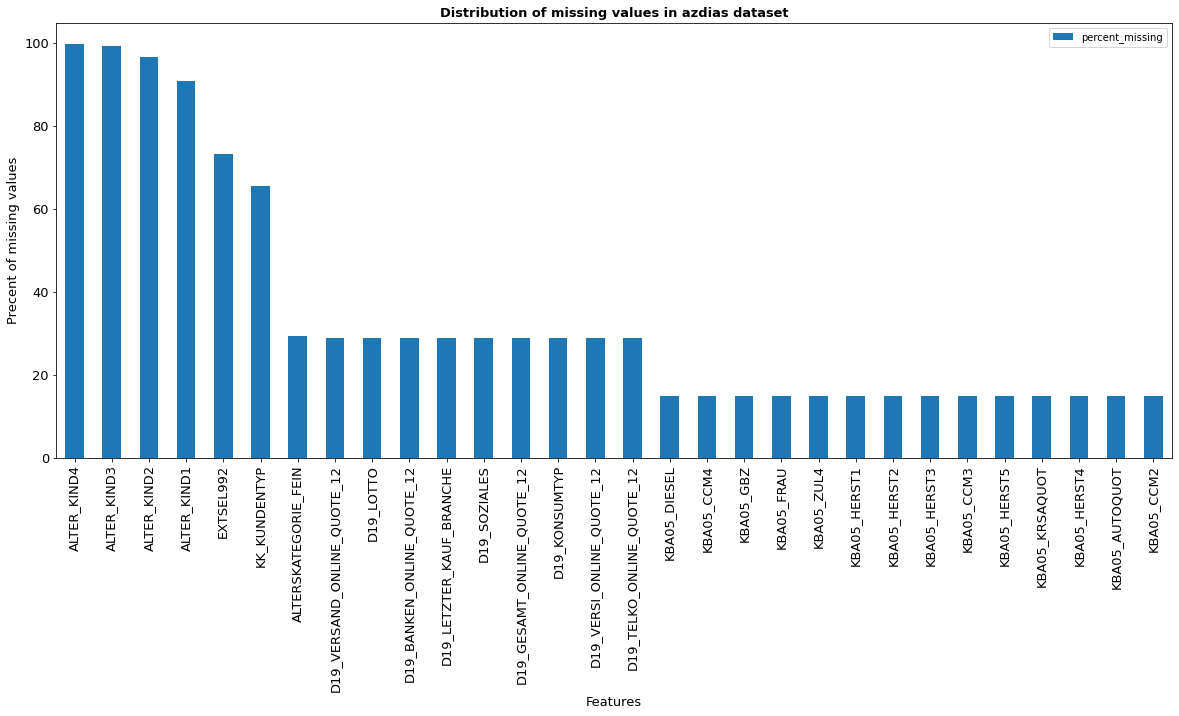

In [9]:
azdias_miss.head(30).plot(kind='bar', figsize=(20,8), fontsize=13)
plt.title("Distribution of missing values in azdias dataset",fontsize=13,fontweight="bold")
plt.xlabel("Features", fontsize=13)
plt.ylabel("Precent of missing values", fontsize=13)

In [10]:
cust_miss = find_missing_vals(customers)

Text(0, 0.5, 'Precent of missing values')

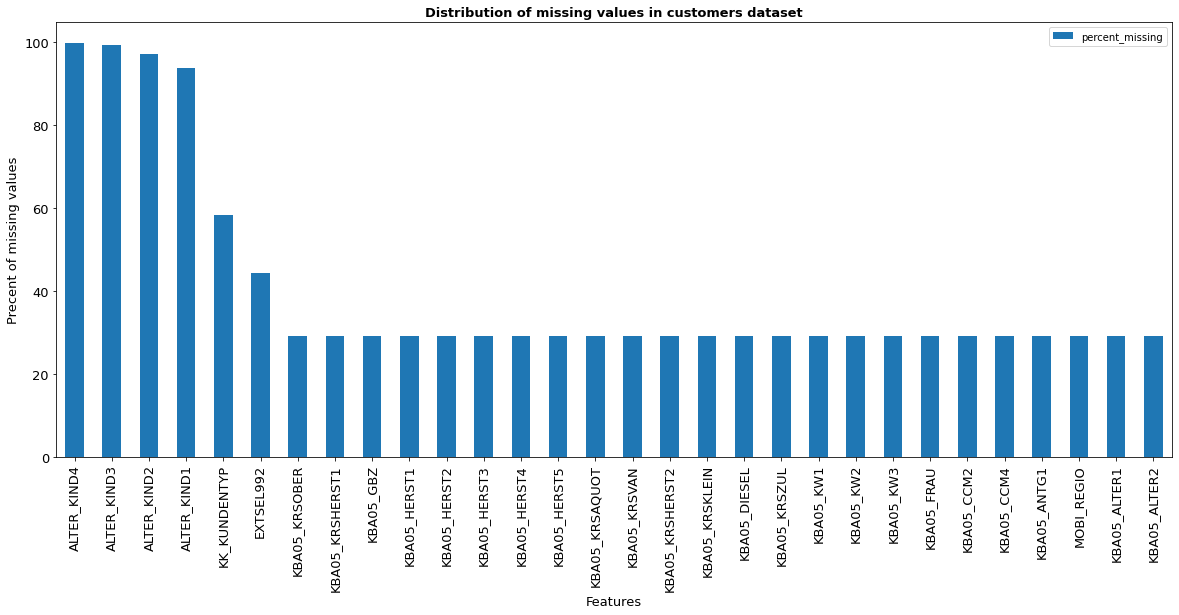

In [11]:
cust_miss.head(30).plot(kind='bar', figsize=(20,8), fontsize=13)
plt.title("Distribution of missing values in customers dataset", fontsize=13, fontweight="bold")
plt.xlabel("Features", fontsize=13)
plt.ylabel("Precent of missing values", fontsize=13)

In [12]:
# Find the columns that have > 50% of missing values
azdias_drop = azdias_miss[azdias_miss['percent_missing'] > 50]
azdias_drop

,column_name,percent_missing
ALTER_KIND4,ALTER_KIND4,99.864792
ALTER_KIND3,ALTER_KIND3,99.307691
ALTER_KIND2,ALTER_KIND2,96.690047
ALTER_KIND1,ALTER_KIND1,90.904837
EXTSEL992,EXTSEL992,73.399639
KK_KUNDENTYP,KK_KUNDENTYP,65.596749


In [13]:
cust_drop = cust_miss[cust_miss['percent_missing']>50]
cust_drop

,column_name,percent_missing
ALTER_KIND4,ALTER_KIND4,99.876860
ALTER_KIND3,ALTER_KIND3,99.334732
ALTER_KIND2,ALTER_KIND2,97.338927
ALTER_KIND1,ALTER_KIND1,93.860748
KK_KUNDENTYP,KK_KUNDENTYP,58.406382


In [14]:
# We see that the set of columns is very similar apart from the EXTSEL992 column which is not in the provided schema.
# Hence let's remove those columns.
azdias_clean = azdias.drop(azdias_drop[azdias_drop['percent_missing']>50]['column_name'], axis = 1)
customers_clean = customers.drop(azdias_drop[azdias_drop['percent_missing']>50]['column_name'], axis = 1)

In [15]:
# Now let's swap -1s for NA and repeat the process.
azdias_clean = azdias_clean.replace(-1, np.nan)
customers_clean = customers_clean.replace(-1, np.nan)

Text(0, 0.5, 'Precent of missing values')

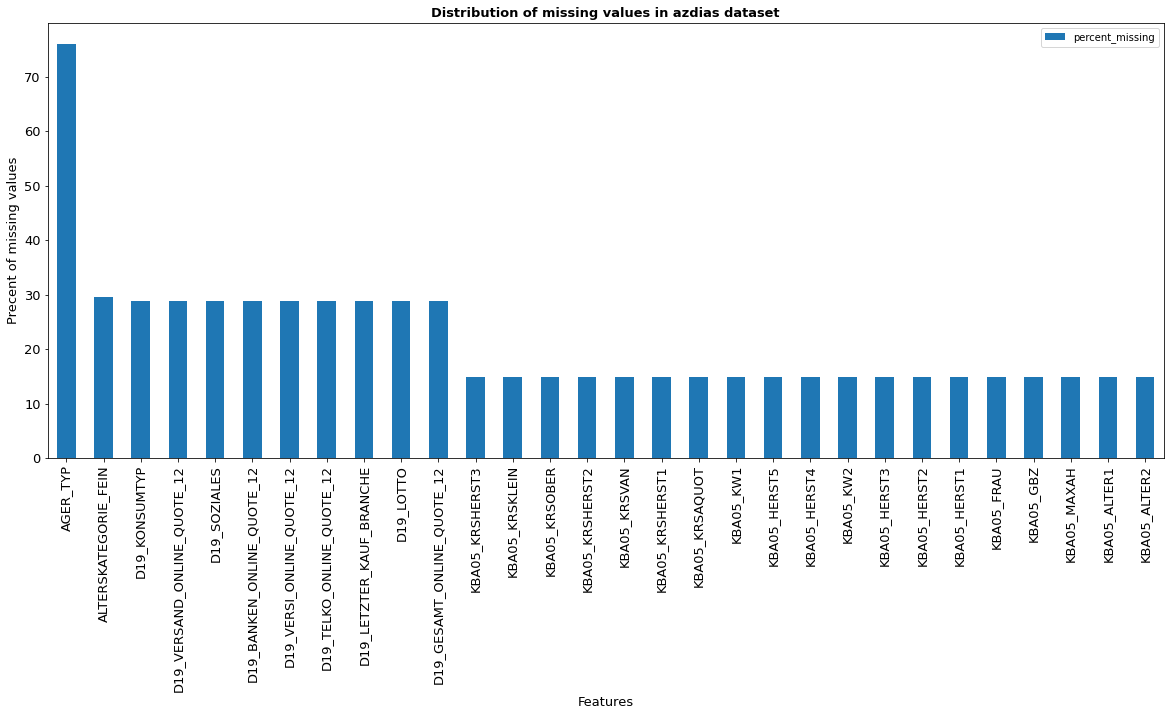

In [16]:
azdias_miss = find_missing_vals(azdias_clean)

azdias_miss.head(30).plot(kind='bar', figsize=(20,8), fontsize=13)
plt.title("Distribution of missing values in azdias dataset",fontsize=13,fontweight="bold")
plt.xlabel("Features", fontsize=13)
plt.ylabel("Precent of missing values", fontsize=13)

Text(0, 0.5, 'Precent of missing values')

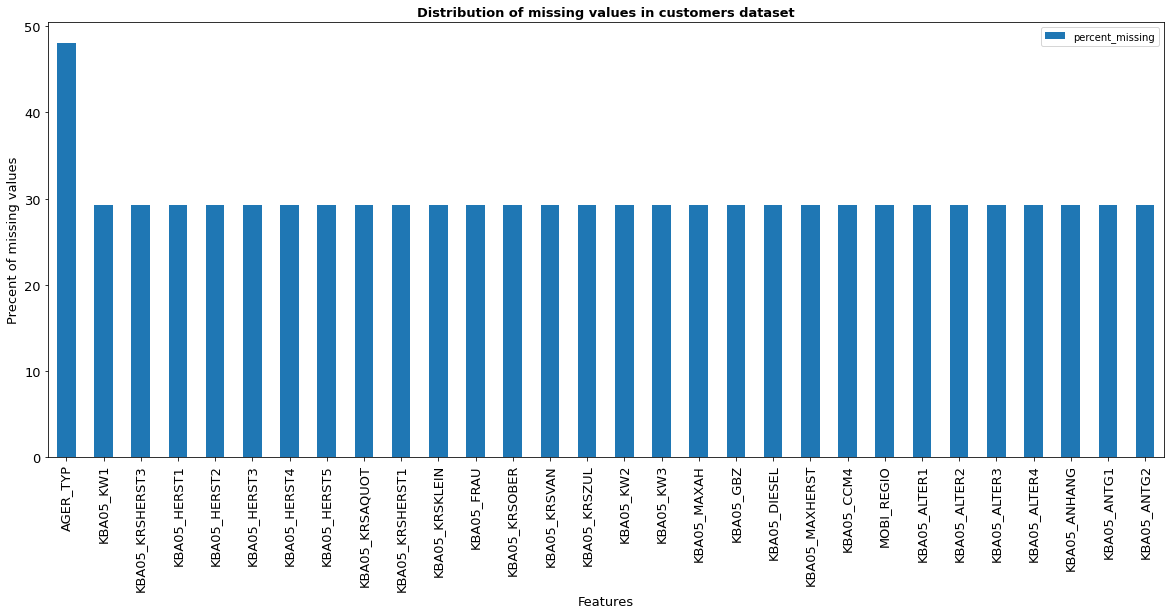

In [17]:
customers_miss = find_missing_vals(customers_clean)

customers_miss.head(30).plot(kind='bar', figsize=(20,8), fontsize=13)
plt.title("Distribution of missing values in customers dataset",fontsize=13,fontweight="bold")
plt.xlabel("Features", fontsize=13)
plt.ylabel("Precent of missing values", fontsize=13)

In [18]:
# Find the columns that have > 25% of missing values
azdias_drop = azdias_miss[azdias_miss['percent_missing'] > 25]
azdias_drop

,column_name,percent_missing
AGER_TYP,AGER_TYP,76.019640
ALTERSKATEGORIE_FEIN,ALTERSKATEGORIE_FEIN,29.504130
D19_KONSUMTYP,D19_KONSUMTYP,28.849522
D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_ONLINE_QUOTE_12,28.849522
D19_SOZIALES,D19_SOZIALES,28.849522
D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_ONLINE_QUOTE_12,28.849522
D19_VERSI_ONLINE_QUOTE_12,D19_VERSI_ONLINE_QUOTE_12,28.849522
D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_ONLINE_QUOTE_12,28.849522
D19_LETZTER_KAUF_BRANCHE,D19_LETZTER_KAUF_BRANCHE,28.849522
D19_LOTTO,D19_LOTTO,28.849522


In [19]:
# Let's remove those columns.
azdias_clean = azdias_clean.drop(azdias_drop[azdias_drop['percent_missing']>25]['column_name'], axis = 1)
customers_clean = customers_clean.drop(azdias_drop[azdias_drop['percent_missing']>25]['column_name'], axis = 1)

In [20]:
azdias_clean.head()

,LNR,AKT_DAT_KL,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,9.0,0.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,9.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,1.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,1.0,20.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [21]:
customers_clean.head()

,LNR,AKT_DAT_KL,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,1.0,10.0,1.0,0.0,0.0,2.0,1.0,0.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,9.0,11.0,NaN,NaN,0.0,3.0,NaN,0.0,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,1.0,6.0,1.0,0.0,0.0,1.0,1.0,0.0,3.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1.0,8.0,0.0,NaN,0.0,0.0,1.0,0.0,1.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,1.0,20.0,7.0,0.0,0.0,4.0,7.0,0.0,3.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [22]:
### Make sure we have numerical attributes only

In [23]:
azdias_clean.dtypes.value_counts()

float64    255
int64       89
object       5
dtype: int64

In [24]:
azdias_clean.dtypes[azdias_clean.dtypes == 'object']

CAMEO_DEU_2015     object
CAMEO_DEUG_2015    object
CAMEO_INTL_2015    object
EINGEFUEGT_AM      object
OST_WEST_KZ        object
dtype: object

In [25]:
azdias_clean[['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015', 'EINGEFUEGT_AM', 'OST_WEST_KZ']]

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,EINGEFUEGT_AM,OST_WEST_KZ
0,NaN,NaN,NaN,NaN,NaN
1,8A,8,51,1992-02-10 00:00:00,W
2,4C,4,24,1992-02-12 00:00:00,W
3,2A,2,12,1997-04-21 00:00:00,W
4,6B,6,43,1992-02-12 00:00:00,W
...,...,...,...,...,...
891216,7A,7,41,1992-02-10 00:00:00,W
891217,9D,9,51,1992-02-10 00:00:00,W
891218,4C,4,24,1992-02-10 00:00:00,W
891219,9D,9,51,1992-02-12 00:00:00,W


In [26]:
azdias_clean['CAMEO_DEUG_2015'].value_counts()

8      78023
9      62578
6      61253
4      60185
8.0    56418
3      50360
2      48276
9.0    45599
7      45021
6.0    44621
4.0    43727
3.0    36419
2.0    34955
7.0    32912
5      32292
5.0    23018
1      20997
1.0    15215
X        373
Name: CAMEO_DEUG_2015, dtype: int64

In [27]:
azdias_clean['CAMEO_INTL_2015'].value_counts()

51      77576
51.0    56118
41      53459
24      52882
41.0    38877
24.0    38276
14      36524
43      32730
14.0    26360
54      26207
43.0    23942
25      22837
54.0    19184
22      19173
25.0    16791
23      15653
13      15272
45      15206
22.0    13982
55      13842
52      11836
23.0    11097
13.0    11064
31      11041
45.0    10926
34      10737
55.0    10113
15       9832
52.0     8706
44       8543
31.0     7983
34.0     7787
12       7645
15.0     7142
44.0     6277
35       6090
32       6067
33       5833
12.0     5604
32.0     4287
35.0     4266
33.0     4102
XX        373
Name: CAMEO_INTL_2015, dtype: int64

In [28]:
azdias_clean['OST_WEST_KZ'].value_counts()

W    629528
O    168545
Name: OST_WEST_KZ, dtype: int64

In [29]:
## Clean the object columns for azdias
## We need to:
## 1. Replace strings like X or XX with missing values
## 2. Modify categorical variables to become dummy variables
## 3. Drop other column types
azdias_clean = azdias_clean.replace('X', np.nan).replace('XX', np.nan)
azdias_clean['CAMEO_DEUG_2015'] = pd.to_numeric(azdias_clean["CAMEO_DEUG_2015"])
azdias_clean['CAMEO_INTL_2015'] = pd.to_numeric(azdias_clean["CAMEO_INTL_2015"])
azdias_clean['OST_WEST_KZ'] = [1 if x == 'W' else 0 for x in azdias_clean['OST_WEST_KZ']]
azdias_clean = azdias_clean.drop(['CAMEO_DEU_2015', 'EINGEFUEGT_AM'], axis=1)

azdias_clean.dtypes.value_counts()

float64    257
int64       90
dtype: int64

In [30]:
customers_clean.dtypes.value_counts()

float64    255
int64       90
object       7
dtype: int64

In [31]:
customers_clean.dtypes[customers_clean.dtypes == 'object']

CAMEO_DEU_2015     object
CAMEO_DEUG_2015    object
CAMEO_INTL_2015    object
EINGEFUEGT_AM      object
OST_WEST_KZ        object
PRODUCT_GROUP      object
CUSTOMER_GROUP     object
dtype: object

In [32]:
customers_clean[['PRODUCT_GROUP', 'CUSTOMER_GROUP']]

,PRODUCT_GROUP,CUSTOMER_GROUP
0,COSMETIC_AND_FOOD,MULTI_BUYER
1,FOOD,SINGLE_BUYER
2,COSMETIC_AND_FOOD,MULTI_BUYER
3,COSMETIC,MULTI_BUYER
4,FOOD,MULTI_BUYER
...,...,...
191647,COSMETIC_AND_FOOD,MULTI_BUYER
191648,COSMETIC,SINGLE_BUYER
191649,COSMETIC_AND_FOOD,MULTI_BUYER
191650,FOOD,SINGLE_BUYER


In [33]:
customers_clean['PRODUCT_GROUP'].value_counts()

COSMETIC_AND_FOOD    100860
FOOD                  47382
COSMETIC              43410
Name: PRODUCT_GROUP, dtype: int64

In [34]:
customers_clean['CUSTOMER_GROUP'].value_counts()

MULTI_BUYER     132238
SINGLE_BUYER     59414
Name: CUSTOMER_GROUP, dtype: int64

In [35]:
## Clean the object columns for customers
## We need to:
## 1. Replace strings like X or XX with missing values
## 2. Modify categorical variables to become dummy variables
## 3. Drop other column types
customers_clean = customers_clean.replace('X', np.nan).replace('XX', np.nan)
customers_clean['CAMEO_DEUG_2015'] = pd.to_numeric(customers_clean["CAMEO_DEUG_2015"])
customers_clean['CAMEO_INTL_2015'] = pd.to_numeric(customers_clean["CAMEO_INTL_2015"])
customers_clean['OST_WEST_KZ'] = [1 if x == 'W' else 0 for x in customers_clean['OST_WEST_KZ']]
customers_clean['CUSTOMER_GROUP_MULTI'] = [1 if x == 'MULTI_BUYER' else 0 for x in customers_clean['CUSTOMER_GROUP']]
customers_clean['PRODUCT_GROUP_FOOD'] = [1 if x == 'FOOD' else 0 for x in customers_clean['PRODUCT_GROUP']]
customers_clean['PRODUCT_GROUP_COSMETIC_AND_FOOD'] = [1 if x == 'COSMETIC_AND_FOOD' else 0 for x in customers_clean['PRODUCT_GROUP']]
customers_clean = customers_clean.drop(['CAMEO_DEU_2015', 'EINGEFUEGT_AM', 'PRODUCT_GROUP', 'CUSTOMER_GROUP'], axis=1)

customers_clean.dtypes.value_counts()

float64    257
int64       94
dtype: int64

### 0.2 Dealing with outliers

In [36]:
azdias_clean.describe()

,LNR,AKT_DAT_KL,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,8.912210e+05,817722.000000,817722.000000,798073.000000,794213.000000,817722.000000,817722.000000,798073.000000,817722.000000,794005.000000,...,770025.000000,815304.000000,815304.000000,815304.000000,783619.000000,817722.000000,798073.000000,891221.000000,891221.000000,891221.000000
mean,6.372630e+05,4.421928,10.864126,8.287263,0.040647,0.154018,1.727637,7.599356,0.004162,3.167854,...,2.417322,6.001214,7.532130,5.945972,3.933406,7.908791,4.052836,3.362438,1.522098,2.777398
std,2.572735e+05,3.638805,7.639683,15.628087,0.324028,0.502389,1.155849,14.332201,0.068855,1.002376,...,1.166572,2.856091,3.247789,2.771464,1.964701,1.923137,1.949539,1.352704,0.499512,1.068775
min,1.916530e+05,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,4.144580e+05,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,3.000000,...,2.000000,3.000000,5.000000,4.000000,2.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,6.372630e+05,3.000000,13.000000,4.000000,0.000000,0.000000,1.000000,3.000000,0.000000,3.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,8.600680e+05,9.000000,17.000000,9.000000,0.000000,0.000000,2.000000,9.000000,0.000000,4.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000
max,1.082873e+06,9.000000,21.000000,595.000000,23.000000,11.000000,45.000000,449.000000,6.000000,9.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


In [37]:
customers_clean.describe()

,LNR,AKT_DAT_KL,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB,CUSTOMER_GROUP_MULTI,PRODUCT_GROUP_FOOD,PRODUCT_GROUP_COSMETIC_AND_FOOD
count,191652.000000,145056.000000,145056.000000,141725.000000,139542.000000,145056.000000,145056.000000,141725.000000,145056.000000,141176.000000,...,137910.000000,145056.000000,141725.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000
mean,95826.500000,1.747525,11.352009,4.965863,0.067413,0.136402,2.267828,4.701288,0.020392,2.824850,...,4.152716,8.646371,3.723133,2.576806,0.090247,1.376432,3.060907,0.689990,0.247229,0.526266
std,55325.311233,1.966334,6.275026,14.309694,0.545576,0.493249,1.390620,14.184081,0.152234,1.012415,...,1.974375,1.154001,2.095540,1.168486,0.286536,0.484492,1.086254,0.462498,0.431402,0.499311
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,47913.750000,1.000000,8.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,2.000000,...,2.000000,9.000000,2.000000,1.000000,0.000000,1.000000,3.000000,0.000000,0.000000,0.000000
50%,95826.500000,1.000000,11.000000,1.000000,0.000000,0.000000,2.000000,1.000000,0.000000,3.000000,...,5.000000,9.000000,3.000000,3.000000,0.000000,1.000000,3.000000,1.000000,0.000000,1.000000
75%,143739.250000,1.000000,16.000000,4.000000,0.000000,0.000000,3.000000,3.000000,0.000000,4.000000,...,6.000000,9.000000,5.000000,3.000000,0.000000,2.000000,4.000000,1.000000,0.000000,1.000000
max,191652.000000,9.000000,21.000000,523.000000,23.000000,8.000000,21.000000,375.000000,5.000000,9.000000,...,6.000000,9.000000,8.000000,6.000000,1.000000,2.000000,9.000000,1.000000,1.000000,1.000000


We see that there is a lot of columns with some extreme values deviating from both the mean and the mean +- 2 standard deviations. For example, for azdias, the mean of ANZ_HAUSHALTE_AKTIV column is 8.29 with standard deviation of 15.62 but we have a value as extreme as 595. We should make sure we treat such outliers. We will use the Tukey rule to remove outliers. 

In [38]:
def tukey_rule(data_frame, column_name):
    data = data_frame[column_name]
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)

    IQR = Q3 - Q1

    max_value = Q3 + 1.5 * IQR
    min_value = Q1 - 1.5 * IQR

    return data_frame[(data_frame[column_name] < max_value) & (data_frame[column_name] > min_value)]

If we just run tukey rule on this data set we would remove... all the rows! Hence some standard deviations must be very large - let's find those columns.

In [39]:
azdias_clean.iloc[:,(-azdias_clean.std()).argsort()]

,LNR,GEBURTSJAHR,KBA13_ANZAHL_PKW,ANZ_HAUSHALTE_AKTIV,ANZ_STATISTISCHE_HAUSHALTE,CAMEO_INTL_2015,LP_LEBENSPHASE_FEIN,GEMEINDETYP,VERDICHTUNGSRAUM,ALTER_HH,...,D19_VERSI_ONLINE_DATUM,KBA13_KRSSEG_KLEIN,HH_DELTA_FLAG,UNGLEICHENN_FLAG,D19_TELKO_ANZ_12,D19_TELKO_ONLINE_DATUM,DSL_FLAG,SOHO_KZ,TITEL_KZ,ANZ_TITEL
0,910215,0,NaN,NaN,NaN,NaN,15.0,NaN,NaN,NaN,...,10,NaN,NaN,NaN,0,10,NaN,NaN,NaN,NaN
1,910220,1996,963.0,11.0,12.0,51.0,21.0,22.0,0.0,0.0,...,10,2.0,0.0,1.0,0,10,1.0,1.0,0.0,0.0
2,910225,1979,712.0,10.0,7.0,24.0,3.0,22.0,1.0,17.0,...,10,2.0,0.0,0.0,0,10,1.0,0.0,0.0,0.0
3,910226,1957,596.0,1.0,2.0,12.0,0.0,40.0,0.0,13.0,...,10,2.0,NaN,0.0,0,10,1.0,0.0,0.0,0.0
4,910241,1963,435.0,3.0,3.0,43.0,32.0,21.0,1.0,20.0,...,10,2.0,0.0,0.0,0,10,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891216,825761,1976,282.0,15.0,11.0,41.0,2.0,NaN,NaN,17.0,...,10,2.0,0.0,0.0,0,10,1.0,0.0,0.0,0.0
891217,825771,1970,592.0,11.0,11.0,51.0,2.0,21.0,0.0,16.0,...,10,2.0,0.0,0.0,0,10,1.0,0.0,0.0,0.0
891218,825772,1976,688.0,3.0,3.0,24.0,0.0,22.0,0.0,17.0,...,10,2.0,NaN,0.0,0,10,1.0,0.0,0.0,0.0
891219,825776,1994,134.0,7.0,5.0,51.0,29.0,12.0,1.0,0.0,...,10,2.0,0.0,0.0,0,10,1.0,0.0,0.0,0.0


In [40]:
azdias_clean.std().sort_values().tail(20)

D19_KONSUMTYP_MAX                  3.225762
VK_DISTANZ                         3.247789
MIN_GEBAEUDEJAHR                   3.332739
LP_STATUS_FEIN                     3.425305
GFK_URLAUBERTYP                    3.525723
AKT_DAT_KL                         3.638805
LP_LEBENSPHASE_GROB                3.855639
LP_FAMILIE_FEIN                    3.926486
PRAEGENDE_JUGENDJAHRE              4.844532
EINGEZOGENAM_HH_JAHR               7.058204
ALTER_HH                           7.639683
VERDICHTUNGSRAUM                   8.471520
GEMEINDETYP                       12.037852
LP_LEBENSPHASE_FEIN               12.616883
CAMEO_INTL_2015                   14.030479
ANZ_STATISTISCHE_HAUSHALTE        14.332201
ANZ_HAUSHALTE_AKTIV               15.628087
KBA13_ANZAHL_PKW                 340.034318
GEBURTSJAHR                      976.583551
LNR                           257273.486465
dtype: float64

Ok, so we probably shouldn't run the Tukey rule on the ordering number or the year of birth...

LNR is the ordering number - that should be dropped.

KBA13_ANZAHL_PKW is the number of cars within the zone - to make sure this doesn't corrupt our data let's drop it too.

ANZ_HAUSHALTE_AKTIV should be a number from 1-10 - remove values from outside this range before applying Tukey rule.

LP_LEBENSPHASE_FEIN should be a number from 1-40 - remove values from outside this range before applying Tukey rule.

ALTER_HH should be a number from 1-21 - remove values from outside this range before applying Tukey rule.

Also note that for categorical variables we shouldn't be using the Tukey rule at all!!!

In [41]:
cat_vars = pd.read_csv("cat_vars.csv")

In [42]:
azdias_outliers_removed = azdias_clean.copy()
customers_outliers_removed = customers_clean.copy()

azdias_outliers_removed = azdias_outliers_removed.drop(['LNR', 'KBA13_ANZAHL_PKW'], axis=1) #dropping LNR as it is ordering number
customers_outliers_removed = customers_outliers_removed.drop(['LNR', 'KBA13_ANZAHL_PKW'], axis=1) #dropping LNR as it is ordering number

azdias_outliers_removed['ANZ_HAUSHALTE_AKTIV'] = [val if val <= 10 and val >= 1 else np.nan for val in azdias_outliers_removed['ANZ_HAUSHALTE_AKTIV']]
azdias_outliers_removed['LP_LEBENSPHASE_FEIN'] = [val if val <= 40 and val >= 1 else np.nan for val in azdias_outliers_removed['LP_LEBENSPHASE_FEIN']]
azdias_outliers_removed['ALTER_HH'] = [val if val <= 21 and val >= 1 else np.nan for val in azdias_outliers_removed['ALTER_HH']]
azdias_outliers_removed = azdias_outliers_removed.drop(['LP_LEBENSPHASE_FEIN', 'GEMEINDETYP', 'VERDICHTUNGSRAUM', 'GEBURTSJAHR', 'EINGEZOGENAM_HH_JAHR', 'MIN_GEBAEUDEJAHR'], axis=1)

customers_outliers_removed['ANZ_HAUSHALTE_AKTIV'] = [val if val <= 10 and val >= 1 else np.nan for val in customers_outliers_removed['ANZ_HAUSHALTE_AKTIV']]
customers_outliers_removed['LP_LEBENSPHASE_FEIN'] = [val if val <= 40 and val >= 1 else np.nan for val in customers_outliers_removed['LP_LEBENSPHASE_FEIN']]
customers_outliers_removed['ALTER_HH'] = [val if val <= 21 and val >= 1 else np.nan for val in customers_outliers_removed['ALTER_HH']]
customers_outliers_removed = customers_outliers_removed.drop(['LP_LEBENSPHASE_FEIN', 'GEMEINDETYP', 'VERDICHTUNGSRAUM', 'GEBURTSJAHR', 'EINGEZOGENAM_HH_JAHR', 'MIN_GEBAEUDEJAHR'], axis=1)

In [43]:
def modified_tukey_rule(data_frame, column_name):
    data = data_frame[column_name]
    Q1 = data.quantile(0.001)
    Q3 = data.quantile(0.999)

    IQR = Q3 - Q1

    max_value = Q3 + 1.5 * IQR
    min_value = Q1 - 1.5 * IQR

    return data_frame[((data_frame[column_name] < max_value) & (data_frame[column_name] > min_value)) | (data_frame[column_name].isna())]

In [44]:
for column in [col for col in list(azdias_outliers_removed.columns) if col not in cat_vars['cat_var']]:
    azdias_outliers_removed = modified_tukey_rule(azdias_outliers_removed, column)
    
for column in [col for col in list(customers_outliers_removed.columns) if col not in cat_vars['cat_var']]:
    customers_outliers_removed = modified_tukey_rule(customers_outliers_removed, column)

In [45]:
azdias_outliers_removed

,AKT_DAT_KL,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,9.0,NaN,NaN,0.0,0.0,2.0,12.0,0.0,3.0,6.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,9.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,2.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,1.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,4.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,1.0,20.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,2.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891216,5.0,17.0,NaN,0.0,0.0,1.0,11.0,0.0,NaN,6.0,...,2.0,4.0,7.0,8.0,3.0,4.0,3.0,4,2,3
891217,9.0,16.0,NaN,0.0,0.0,1.0,11.0,0.0,4.0,7.0,...,4.0,6.0,9.0,6.0,6.0,9.0,5.0,6,1,2
891218,1.0,17.0,3.0,0.0,0.0,0.0,3.0,0.0,2.0,5.0,...,2.0,7.0,10.0,8.0,NaN,5.0,7.0,4,2,2
891219,9.0,NaN,7.0,0.0,1.0,1.0,5.0,0.0,4.0,2.0,...,4.0,9.0,8.0,5.0,1.0,9.0,5.0,5,1,1


In [46]:
azdias_outliers_removed.describe()

,AKT_DAT_KL,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,817227.000000,580671.000000,617630.000000,793727.000000,817227.000000,817227.000000,797585.000000,817227.000000,793527.000000,796993.000000,...,769542.000000,814812.000000,814812.000000,814812.000000,783158.000000,817227.000000,797585.000000,890726.000000,890726.000000,890726.000000
mean,4.421419,15.293677,3.591948,0.036765,0.154070,1.727098,7.528688,0.003866,3.167814,4.153635,...,2.417405,6.000722,7.532438,5.946542,3.932938,7.908713,4.053298,3.362564,1.522088,2.777069
std,3.638670,3.799227,2.803876,0.244271,0.502325,1.147734,13.651807,0.065712,1.002375,2.183454,...,1.166495,2.855809,3.247461,2.771220,1.964688,1.923171,1.949593,1.352814,0.499512,1.068812
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,1.000000,13.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,3.000000,2.000000,...,2.000000,3.000000,5.000000,4.000000,2.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,3.000000,16.000000,2.000000,0.000000,0.000000,1.000000,3.000000,0.000000,3.000000,5.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,9.000000,18.000000,6.000000,0.000000,0.000000,2.000000,9.000000,0.000000,4.000000,6.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000
max,9.000000,21.000000,10.000000,7.000000,9.000000,18.000000,371.000000,2.000000,9.000000,7.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


In [47]:
customers_outliers_removed = customers_clean.copy()

customers_outliers_removed = customers_outliers_removed.drop(['LNR', 'KBA13_ANZAHL_PKW'], axis=1) #dropping LNR as it is ordering number


customers_outliers_removed['ANZ_HAUSHALTE_AKTIV'] = [val if val <= 10 and val >= 1 else np.nan for val in customers_outliers_removed['ANZ_HAUSHALTE_AKTIV']]
customers_outliers_removed['LP_LEBENSPHASE_FEIN'] = [val if val <= 40 and val >= 1 else np.nan for val in customers_outliers_removed['LP_LEBENSPHASE_FEIN']]
customers_outliers_removed['ALTER_HH'] = [val if val <= 21 and val >= 1 else np.nan for val in customers_outliers_removed['ALTER_HH']]
customers_outliers_removed = customers_outliers_removed.drop(['LP_LEBENSPHASE_FEIN', 'GEMEINDETYP', 'VERDICHTUNGSRAUM', 'GEBURTSJAHR', 'EINGEZOGENAM_HH_JAHR', 'MIN_GEBAEUDEJAHR'], axis=1)

for column in [col for col in list(customers_outliers_removed.columns) if col not in cat_vars['cat_var']]:
    customers_outliers_removed = modified_tukey_rule(customers_outliers_removed, column)

In [48]:
customers_outliers_removed

,AKT_DAT_KL,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB,CUSTOMER_GROUP_MULTI,PRODUCT_GROUP_FOOD,PRODUCT_GROUP_COSMETIC_AND_FOOD
0,1.0,10.0,1.0,0.0,0.0,2.0,1.0,0.0,1.0,3.0,...,6.0,9.0,7.0,3,0,1,4,1,0,1
1,9.0,11.0,NaN,NaN,0.0,3.0,NaN,0.0,NaN,NaN,...,0.0,9.0,NaN,3,0,1,4,0,1,0
2,1.0,6.0,1.0,0.0,0.0,1.0,1.0,0.0,3.0,7.0,...,6.0,9.0,2.0,3,0,2,4,1,0,1
3,1.0,8.0,NaN,NaN,0.0,0.0,1.0,0.0,1.0,7.0,...,NaN,9.0,7.0,1,0,1,4,1,0,0
4,1.0,20.0,7.0,0.0,0.0,4.0,7.0,0.0,3.0,3.0,...,2.0,9.0,3.0,1,0,1,3,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191647,1.0,9.0,1.0,0.0,0.0,1.0,1.0,0.0,3.0,1.0,...,6.0,9.0,1.0,3,0,1,3,1,0,1
191648,2.0,NaN,NaN,NaN,0.0,0.0,1.0,0.0,1.0,6.0,...,NaN,9.0,3.0,3,0,2,4,0,0,0
191649,1.0,15.0,1.0,0.0,0.0,3.0,1.0,0.0,3.0,7.0,...,3.0,9.0,3.0,3,0,1,4,1,0,1
191650,1.0,13.0,4.0,0.0,0.0,4.0,3.0,0.0,3.0,3.0,...,4.0,9.0,2.0,3,0,2,3,0,1,0


In [49]:
customers_outliers_removed.describe()

,AKT_DAT_KL,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB,CUSTOMER_GROUP_MULTI,PRODUCT_GROUP_FOOD,PRODUCT_GROUP_COSMETIC_AND_FOOD
count,145030.000000,122884.000000,124746.000000,139516.000000,145030.000000,145030.000000,141699.000000,145030.000000,141150.000000,141667.000000,...,137888.000000,145030.000000,141699.000000,191626.000000,191626.000000,191626.000000,191626.000000,191626.000000,191626.000000,191626.000000
mean,1.747176,13.398221,2.272818,0.064967,0.136427,2.267586,4.665474,0.020341,2.824775,4.302110,...,4.152609,8.646590,3.723230,2.576790,0.090233,1.376405,3.060816,0.689974,0.247237,0.526249
std,1.965854,4.365565,2.194926,0.496478,0.493290,1.388633,13.783343,0.151483,1.012456,2.114448,...,1.974398,1.153538,2.095599,1.168507,0.286516,0.484485,1.086282,0.462505,0.431407,0.499312
min,1.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,1.000000,10.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,2.000000,2.000000,...,2.000000,9.000000,2.000000,1.000000,0.000000,1.000000,3.000000,0.000000,0.000000,0.000000
50%,1.000000,13.000000,1.000000,0.000000,0.000000,2.000000,1.000000,0.000000,3.000000,5.000000,...,5.000000,9.000000,3.000000,3.000000,0.000000,1.000000,3.000000,1.000000,0.000000,1.000000
75%,1.000000,17.000000,2.000000,0.000000,0.000000,3.000000,3.000000,0.000000,4.000000,6.000000,...,6.000000,9.000000,5.000000,3.000000,0.000000,2.000000,4.000000,1.000000,0.000000,1.000000
max,9.000000,21.000000,10.000000,18.000000,8.000000,16.000000,375.000000,3.000000,9.000000,7.000000,...,6.000000,9.000000,8.000000,6.000000,1.000000,2.000000,9.000000,1.000000,1.000000,1.000000


### 0.3 Imputing the rest of the missing values

In [52]:
## For the remiander of the columns, swap missing values for the mean of the attribute.
def replace_nan_with_median(df):
    
    column_medians = df.median()
    df = df.fillna(column_medians)
    
    return df

In [53]:
azdias = replace_nan_with_median(azdias_outliers_removed)
customers = replace_nan_with_median(customers_outliers_removed)

In [54]:
azdias.head()

,AKT_DAT_KL,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,3.0,16.0,2.0,0.0,0.0,1.0,3.0,0.0,3.0,5.0,...,2.0,6.0,8.0,6.0,4.0,9.0,3.0,3,1,2
1,9.0,16.0,2.0,0.0,0.0,2.0,12.0,0.0,3.0,6.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,9.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,2.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,1.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,4.0,...,0.0,7.0,10.0,11.0,4.0,9.0,7.0,3,2,4
4,1.0,20.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,2.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [55]:
customers.head()

,AKT_DAT_KL,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB,CUSTOMER_GROUP_MULTI,PRODUCT_GROUP_FOOD,PRODUCT_GROUP_COSMETIC_AND_FOOD
0,1.0,10.0,1.0,0.0,0.0,2.0,1.0,0.0,1.0,3.0,...,6.0,9.0,7.0,3,0,1,4,1,0,1
1,9.0,11.0,1.0,0.0,0.0,3.0,1.0,0.0,3.0,5.0,...,0.0,9.0,3.0,3,0,1,4,0,1,0
2,1.0,6.0,1.0,0.0,0.0,1.0,1.0,0.0,3.0,7.0,...,6.0,9.0,2.0,3,0,2,4,1,0,1
3,1.0,8.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,7.0,...,5.0,9.0,7.0,1,0,1,4,1,0,0
4,1.0,20.0,7.0,0.0,0.0,4.0,7.0,0.0,3.0,3.0,...,2.0,9.0,3.0,1,0,1,3,1,1,0


In [56]:
azdias.to_csv("azdias.csv", index = False)
customers.to_csv("customers.csv", index = False)

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### 1.1 Create a PCA Pipeline that we will use in our unsupervised training model

As our dataset has a very large number of features, a goid idea is to choose the Principal Component Analysis (PCA) as our unsupervised learning model.

In [57]:
pipeline = Pipeline([ 
    ('impute', SimpleImputer()),
    ('scale', StandardScaler()), 
    ('pca' , PCA()),
])

# Fit the model
azdias_pca_fit = pipeline.fit(azdias)

In [58]:
pca = pipeline[2]

Text(0, 0.5, 'Cumulative Explained Variance Ratio')

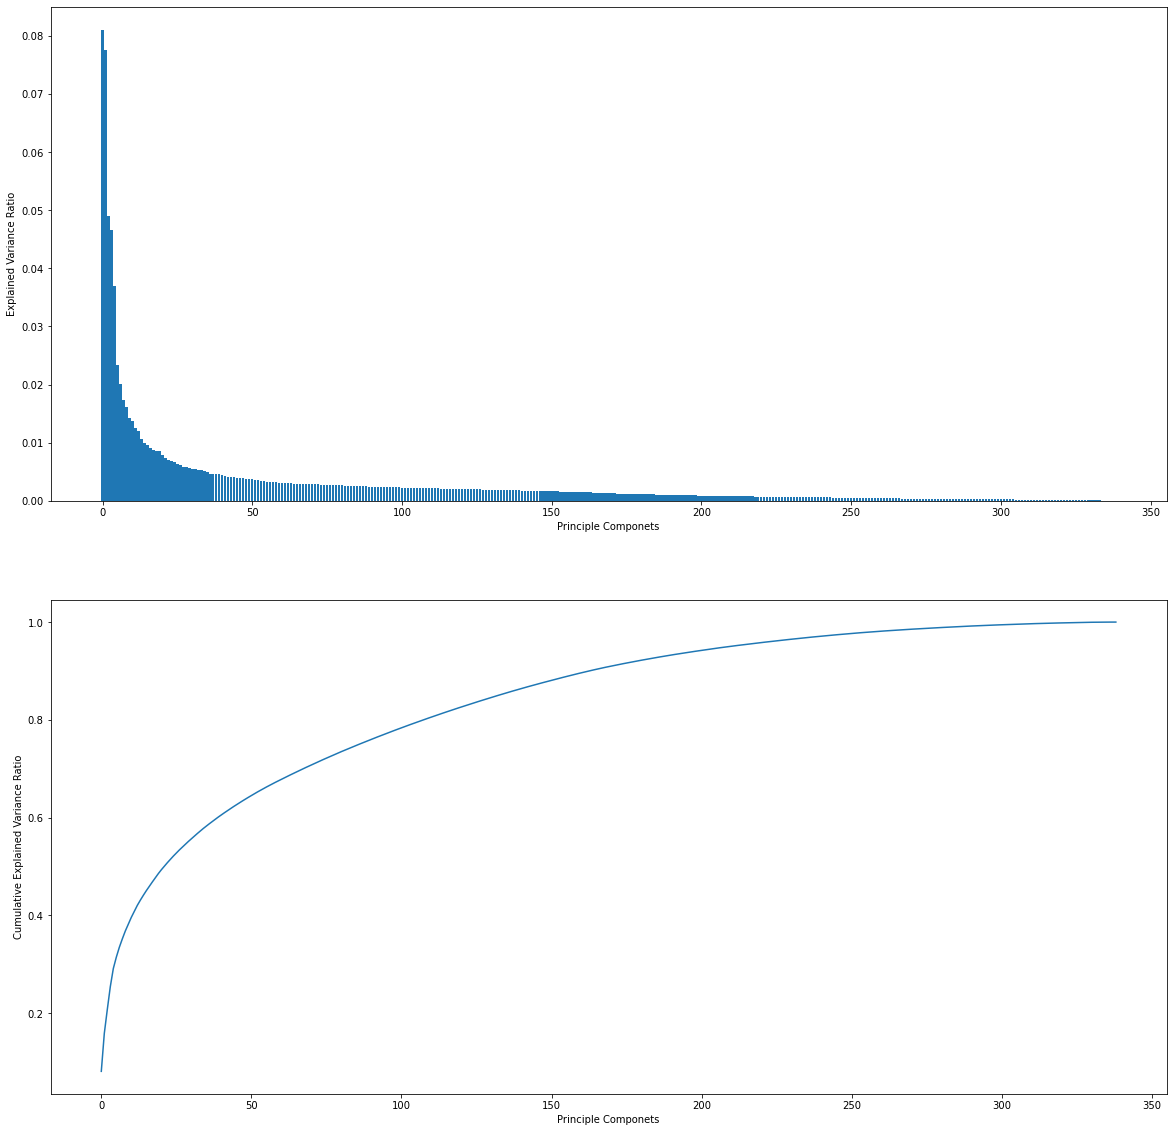

In [59]:
# Investigate the variance accounted for by each principal component.
plt.figure(figsize=(20, 20))
plt.subplot(2,1,1)
plt.bar(list(range(len(pca.explained_variance_ratio_))), pca.explained_variance_ratio_)
plt.xlabel('Principle Componets')
plt.ylabel('Explained Variance Ratio')

plt.subplot(2,1,2)
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.xlabel('Principle Componets')
plt.ylabel('Cumulative Explained Variance Ratio')

Text(0, 0.5, 'Explained Variance Ratio')

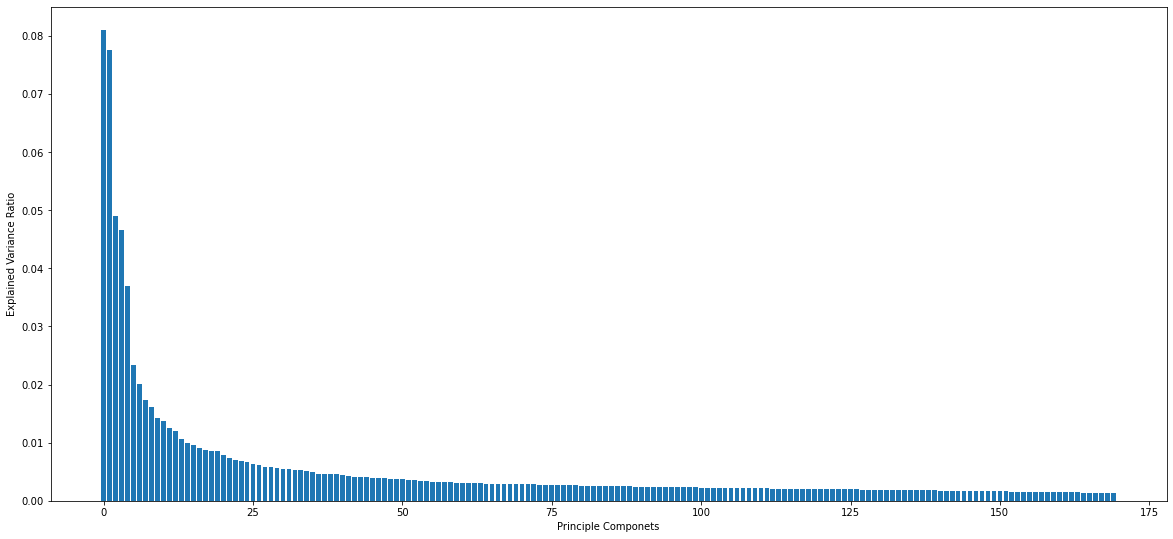

In [60]:
# Investigate the variance accounted for by top 170 principal components.
plt.figure(figsize=(20, 20))
plt.subplot(2,1,1)
plt.bar(list(range(len(pca.explained_variance_ratio_)))[:170], pca.explained_variance_ratio_[:170])
plt.xlabel('Principle Componets')
plt.ylabel('Explained Variance Ratio')

In [61]:
print('The amount of variance explained by top 170 components is {}.'.format(pca.explained_variance_ratio_[:170].sum()))

The amount of variance explained by top 170 components is 0.9088575062057613.


Top 170 components explain over 90% of the variation in the data.

Text(0, 0.5, 'Explained Variance Ratio')

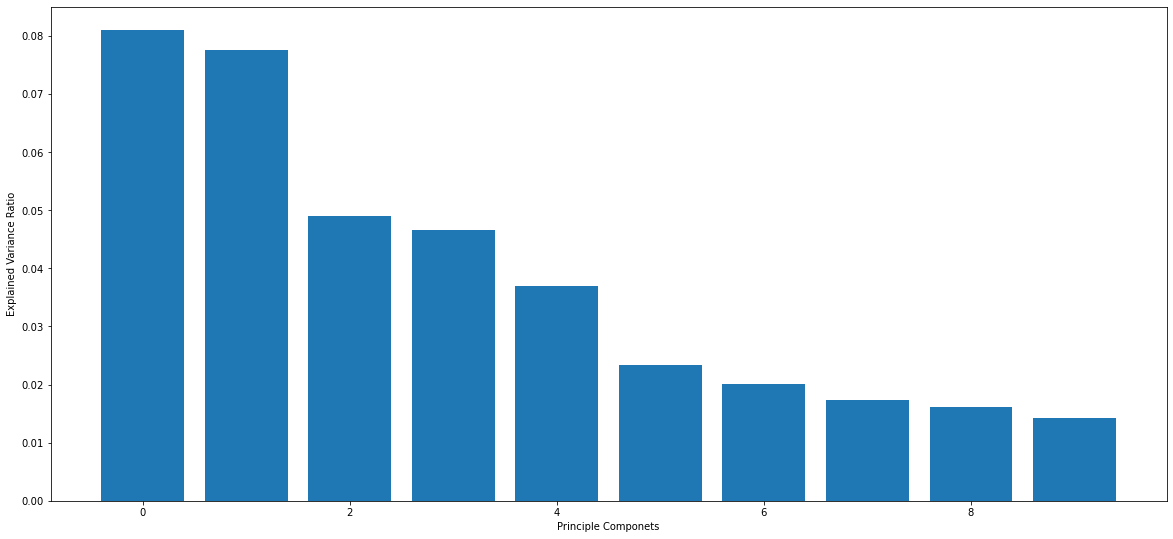

In [62]:
# Investigate the variance accounted for by top 10 principal components.
plt.figure(figsize=(20, 20))
plt.subplot(2,1,1)
plt.bar(list(range(len(pca.explained_variance_ratio_)))[:10], pca.explained_variance_ratio_[:10])
plt.xlabel('Principle Componets')
plt.ylabel('Explained Variance Ratio')

For the purpose of clustering, let's use the first 5 proncipal components.

Let's incorporate the newly obtained PCA scores in the K-means algorithm. That's how we can perform segmentation based on principal components scores instead of the original features.

Let's start with the PCS scores we can obtain via using the fit_transform() method.

In [63]:
# Fit the model with new number of features and transform the data
pipeline = Pipeline([ 
    ('impute', SimpleImputer()),
    ('scale', StandardScaler()), 
    ('pca' , PCA(n_components = 5)),
])

azdias_pca = pipeline.fit_transform(azdias)

In [65]:
wcss = []
n_clusters = 10
for i in range(1, n_clusters):
    kmeans_pca = KMeans(n_clusters = i, init = 'k-means++', random_state = 1)
    kmeans_pca.fit(azdias_pca)
    wcss.append(kmeans_pca.inertia_)

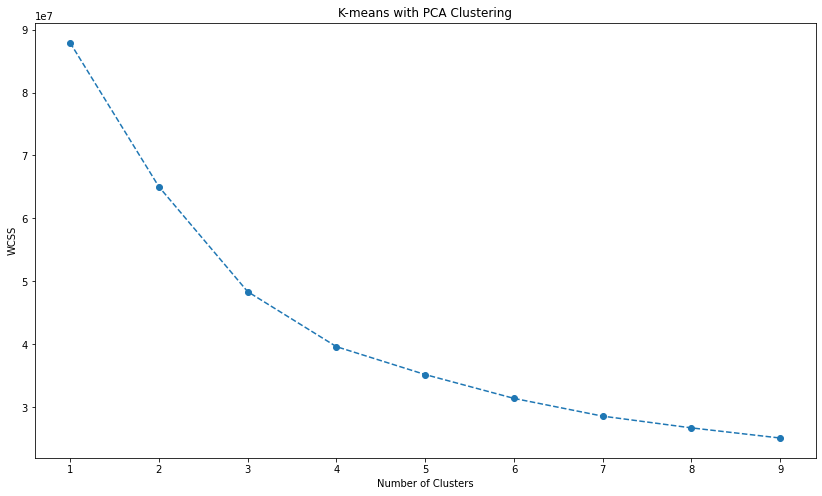

In [66]:
# Plot the WCSS against the number of components - the "elbow curve"
fig = plt.figure(figsize = (14,8))
plt.plot(range(1,n_clusters), wcss, marker = 'o', linestyle = '--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('K-means with PCA Clustering')
plt.show()

Based on the elbow curve, we will choose 4 clusters for our model.

In [67]:
# We have chosen 4 clusters, so we run K-means with number of clusters = 4
# Pick same initializer and random state as before
kmeans_pca = KMeans(n_clusters = 4, init = 'k-means++', random_state = 1)

# Fit the data with K-means PCA 
kmeans_pca.fit(azdias_pca)

KMeans(n_clusters=4, random_state=1)

### 1.2 K-means clustering with PCA results

In [85]:
# Now we can predict the cluster for our customers based on the above results
customers_pca =  pipeline.transform(customers.drop(['ONLINE_PURCHASE', 'CUSTOMER_GROUP_MULTI', 'PRODUCT_GROUP_FOOD', 'PRODUCT_GROUP_COSMETIC_AND_FOOD'], axis=1))
customers_clusters = kmeans_pca.predict(customers_pca)

In [86]:
customers_pca_kmeans = pd.DataFrame(customers_pca)
customers_pca_kmeans.columns = ['Component 1','Component 2','Component 3','Component 4','Component 5']
customers_pca_kmeans['Cluster'] = customers_clusters
customers_pca_kmeans

,Component 1,Component 2,Component 3,Component 4,Component 5,Cluster
0,-5.924665,5.010061,-6.753252,3.191567,1.948587,2
1,-2.651239,1.377279,-3.784982,-0.374152,2.137651,2
2,3.379035,0.810887,-4.738959,1.914654,5.390020,2
3,-4.520845,2.543405,-5.396079,-1.017217,2.513025,2
4,-4.501271,-2.004029,8.068668,-0.562561,2.741708,1
...,...,...,...,...,...,...
191621,-0.475669,2.080295,-3.999936,13.164130,5.116923,2
191622,-3.052916,3.373561,-7.463772,2.111782,0.070908,2
191623,-2.447159,1.609269,-4.230606,0.307177,4.964096,2
191624,-2.838084,-0.291062,3.066752,-0.478613,4.070992,1


In [87]:
customers_pca_kmeans['Cluster'].value_counts()

2    94893
1    77077
0    18724
3      932
Name: Cluster, dtype: int64

/Users/kozersky/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


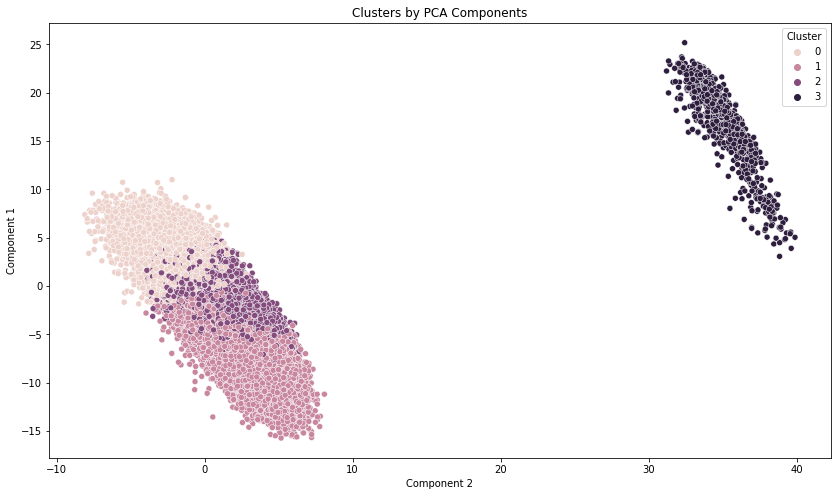

In [88]:
x_axis = customers_pca_kmeans['Component 2']
y_axis = customers_pca_kmeans['Component 1']
fig = plt.figure(figsize = (14,8))
sns.scatterplot(x_axis, y_axis, hue = customers_pca_kmeans['Cluster'])
plt.title('Clusters by PCA Components')
plt.show()

In [95]:
customers_with_clusters = customers.copy()
customers_with_clusters['Cluster'] = customers_clusters

customers_with_clusters0 = customers_with_clusters[customers_with_clusters['Cluster'] == 0]
customers_with_clusters1 = customers_with_clusters[customers_with_clusters['Cluster'] == 1]
customers_with_clusters2 = customers_with_clusters[customers_with_clusters['Cluster'] == 2]
customers_with_clusters3 = customers_with_clusters[customers_with_clusters['Cluster'] == 3]

# Find what are the main differences between the clusters
diff = pd.DataFrame({'Cluster 3': customers_with_clusters3.mean(), 'Cluster 1': customers_with_clusters1.mean()})
diff['delta'] = abs(diff['Cluster 3'] - diff['Cluster 1'])
diff.sort_values(['delta'], ascending = False).head(5)

,Cluster 3,Cluster 1,delta
ANZ_STATISTISCHE_HAUSHALTE,29.930258,1.905367,28.024890
CAMEO_INTL_2015,46.732833,25.058007,21.674826
KBA05_SEG6,9.000000,0.179379,8.820621
KBA05_SEG8,9.000000,0.995589,8.004411
KBA05_SEG7,9.000000,1.038857,7.961143


## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [231]:
mailout_train = pd.read_csv('../Capstone/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/Users/kozersky/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [232]:
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [233]:
mailout_train.shape

(42962, 367)

### 2.1 Clean the data

In [234]:
## Take only the columns as we had before
mailout_train = mailout_train[list(azdias.columns) + ['RESPONSE', 'LNR']]

In [235]:
## Clean the data
mailout_train_miss = find_missing_vals(mailout_train)

Text(0, 0.5, 'Precent of missing values')

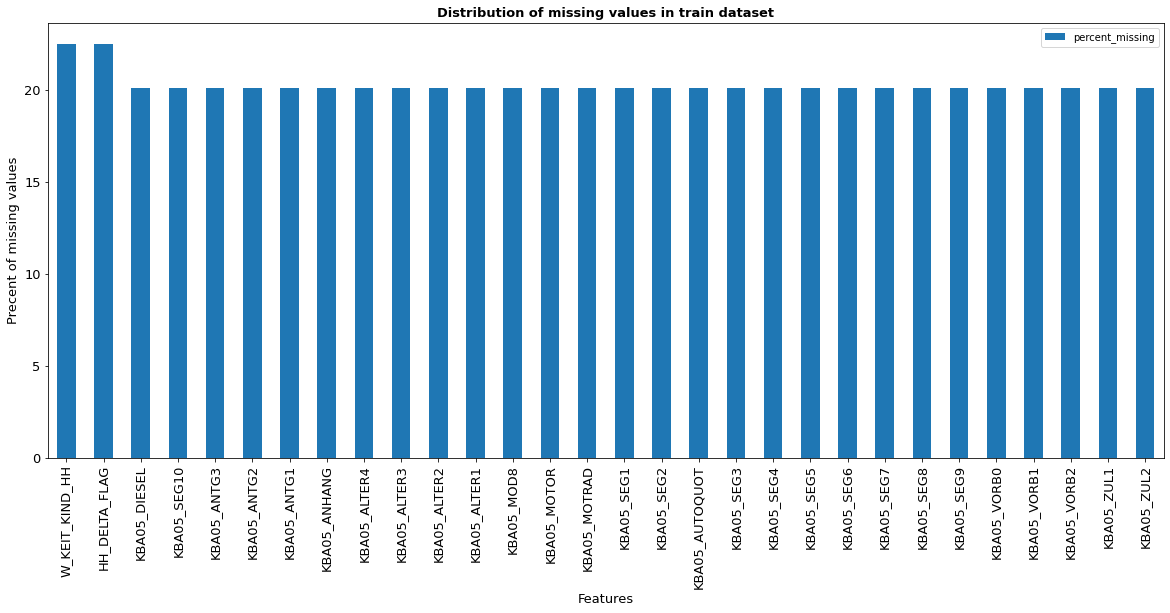

In [236]:
mailout_train_miss.head(30).plot(kind='bar', figsize=(20,8), fontsize=13)
plt.title("Distribution of missing values in train dataset", fontsize=13, fontweight="bold")
plt.xlabel("Features", fontsize=13)
plt.ylabel("Precent of missing values", fontsize=13)

That is fine, we don't need to remove any other features.

In [237]:
mailout_train.dtypes.value_counts()

float64    246
int64       92
object       3
dtype: int64

In [238]:
mailout_train.dtypes[mailout_train.dtypes == 'object']

CAMEO_DEUG_2015    object
CAMEO_INTL_2015    object
OST_WEST_KZ        object
dtype: object

In [239]:
mailout_train['CAMEO_DEUG_2015'].value_counts()

6.0    3884
4.0    3685
8.0    3569
2.0    3333
3.0    3105
7.0    2201
5.0    1841
9.0    1747
1.0    1682
6      1479
4      1446
8      1441
2      1370
3      1318
7       863
9       713
1       696
5       690
X        11
Name: CAMEO_DEUG_2015, dtype: int64

In [240]:
mailout_train['CAMEO_INTL_2015'].value_counts()

24.0    3024
14.0    2596
51.0    2309
41.0    2212
43.0    1776
25.0    1733
45.0    1363
54.0    1326
24      1186
22.0    1182
13.0    1139
14      1078
55.0    1075
51       905
41       852
23.0     851
15.0     846
25       722
34.0     692
43       676
44.0     558
45       543
31.0     532
54       530
22       502
13       494
55       471
12.0     434
35.0     426
23       354
15       331
52.0     329
32.0     328
33.0     316
34       273
44       203
31       193
35       188
12       163
52       136
32       110
33       106
XX        11
Name: CAMEO_INTL_2015, dtype: int64

In [241]:
mailout_train['OST_WEST_KZ'].value_counts()

W    26752
O     8433
Name: OST_WEST_KZ, dtype: int64

In [242]:
## Clean the object columns for azdias
## We need to:
## 1. Replace strings like X or XX with missing values
## 2. Modify categorical variables to become dummy variables
## 3. Drop other column types
mailout_train = mailout_train.replace('X', np.nan).replace('XX', np.nan)
mailout_train['CAMEO_DEUG_2015'] = pd.to_numeric(mailout_train["CAMEO_DEUG_2015"])
mailout_train['CAMEO_INTL_2015'] = pd.to_numeric(mailout_train["CAMEO_INTL_2015"])
mailout_train['OST_WEST_KZ'] = [1 if x == 'W' else 0 for x in mailout_train['OST_WEST_KZ']]

mailout_train.dtypes.value_counts()

float64    248
int64       93
dtype: int64

In [243]:
mailout_train = replace_nan_with_median(mailout_train)

In [244]:
mailout_train.head()

,AKT_DAT_KL,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,RESPONSE,LNR
0,1.0,8.0,15.0,0.0,0.0,1.0,13.0,0.0,3.0,5.0,...,2.0,1.0,6.0,9.0,3.0,3,2,4,0,1763
1,4.0,13.0,1.0,0.0,0.0,2.0,1.0,0.0,2.0,5.0,...,2.0,1.0,4.0,9.0,7.0,1,2,3,0,1771
2,1.0,9.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,1.0,...,4.0,2.0,6.0,9.0,2.0,3,1,4,0,1776
3,1.0,6.0,4.0,0.0,0.0,2.0,4.0,0.0,4.0,2.0,...,11.0,11.0,6.0,9.0,1.0,3,2,4,0,1460
4,1.0,9.0,53.0,0.0,0.0,1.0,44.0,0.0,3.0,4.0,...,2.0,1.0,6.0,9.0,3.0,3,1,3,0,1783


### 2.2 Investigate the response variable

/Users/kozersky/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='RESPONSE', ylabel='count'>

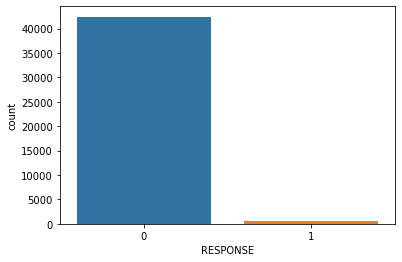

In [245]:
sns.countplot("RESPONSE", data=mailout_train)

The response variable is binary, so I think it will be a good idea to try three models: a logistic regression, XGBoost Classifier and LGBM Classifier.

In [248]:
X = mailout_train.drop(['RESPONSE', 'LNR'], axis = 1)
y = mailout_train['RESPONSE']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

models = {'LR': LogisticRegression(), 'LGBM': LGBMClassifier()}

metric_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

# Now let's use each model and compare their performance
for model in models:
    pipeline = Pipeline([
        ('impute', SimpleImputer()),
        ('scale', StandardScaler()), 
        ('clf', models[model])
    ])
    pipeline.fit(X_train, y_train)
    
    y_proba = pipeline.predict_proba(X_test)[::,1]
    
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    
    metric_table = metric_table.append({'classifier':models[model].__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)



/Users/kozersky/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [249]:
metric_table[['classifier', 'auc']]

,classifier,auc
0,LogisticRegression,0.627484
1,LGBMClassifier,0.641278


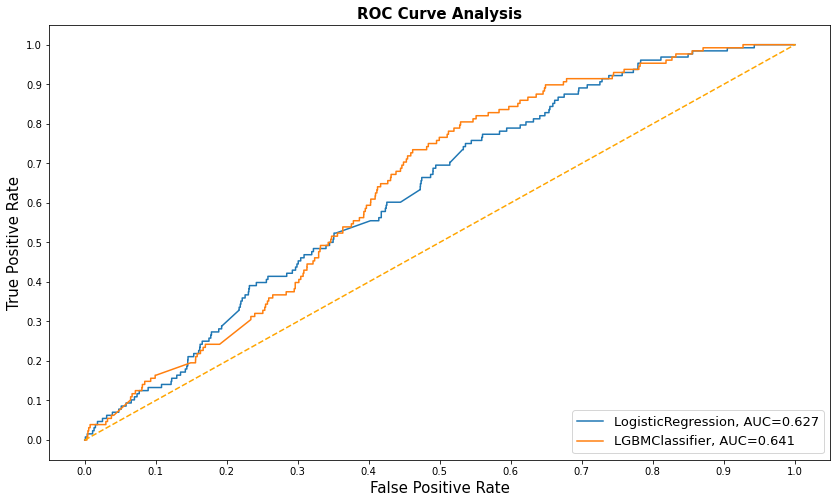

In [250]:
fig = plt.figure(figsize=(14,8))

for i in metric_table.index:
    plt.plot(metric_table.loc[i]['fpr'], 
             metric_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(metric_table.loc[i]['classifier'], metric_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

At the moment it looks like LGBM performs better with AUC = 0.641. For now it's not a bad start, but we could try to improve those results.

Note that we got the error for the logistic regression /Users/kozersky/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

We can try to take this into account to improve our Logistic Regression.

In [251]:
X = mailout_train.drop(['RESPONSE'], axis = 1)
y = mailout_train['RESPONSE']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

models = {'LR': LogisticRegression(max_iter=10000), 'LGBM': LGBMClassifier()}

metric_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

# Now let's use each model and compare their performance
for model in models:
    pipeline = Pipeline([
        ('impute', SimpleImputer()),
        ('scale', StandardScaler()), 
        ('clf', models[model])
    ])
    pipeline.fit(X_train, y_train)
    
    y_proba = pipeline.predict_proba(X_test)[::,1]
    
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    
    metric_table = metric_table.append({'classifier':models[model].__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

In [252]:
metric_table[['classifier', 'auc']]

,classifier,auc
0,LogisticRegression,0.628670
1,LGBMClassifier,0.656713


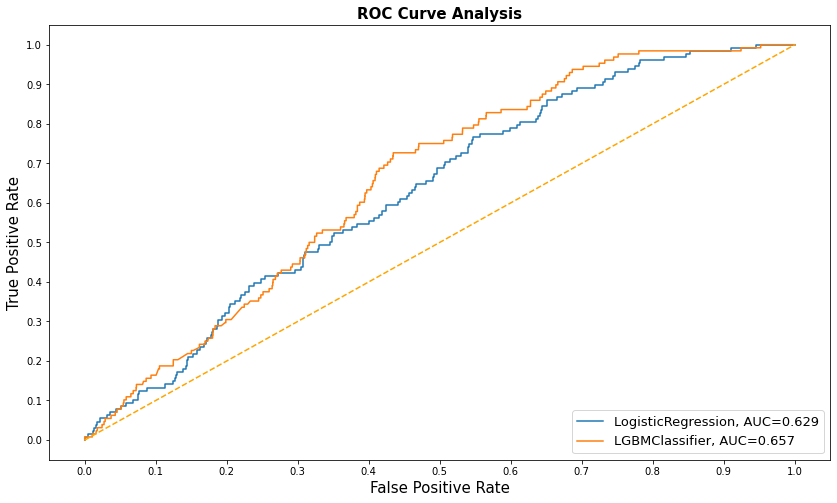

In [253]:
fig = plt.figure(figsize=(14,8))

for i in metric_table.index:
    plt.plot(metric_table.loc[i]['fpr'], 
             metric_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(metric_table.loc[i]['classifier'], metric_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

That did improve AUC but not by a lot. Another thing we can try is to perform a Grid Search. Let's try it for LGBM as it's the better performing model.

In [254]:
## Inspired by https://www.kaggle.com/bitit1994/parameter-grid-search-lgbm-with-scikit-learn
gridParams = {
    'learning_rate': [0.005, 0.01],
    'n_estimators': [8,16],
    'num_leaves': [8,12,16], # large num_leaves helps improve accuracy but might lead to over-fitting
    'objective' : ['binary'],
    'random_state' : [500],
    'reg_lambda' : [1,1.2,1.4],
    }

grid = GridSearchCV(LGBMClassifier(), gridParams, verbose=1, cv=4, n_jobs=-1)
# Run the grid
grid.fit(X, y)

# Print the best parameters found
print(grid.best_params_)
print(grid.best_score_)

Fitting 4 folds for each of 36 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:  2.1min finished


{'learning_rate': 0.005, 'n_estimators': 8, 'num_leaves': 8, 'objective': 'binary', 'random_state': 500, 'reg_lambda': 1}
0.9876169638016635


In [260]:
X = mailout_train.drop(['RESPONSE'], axis = 1)
y = mailout_train['RESPONSE']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

models = {'LR': LogisticRegression(max_iter=10000),
          'LGBM': LGBMClassifier(learning_rate= 0.005, n_estimators=8, num_leaves= 8, objective= 'binary', random_state= 0, reg_lambda= 1)}

metric_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

# Now let's use each model and compare their performance
for model in models:
    pipeline = Pipeline([
        ('impute', SimpleImputer()),
        ('scale', StandardScaler()), 
        ('clf', models[model])
    ])
    pipeline.fit(X_train, y_train)
    
    y_proba = pipeline.predict_proba(X_test)[::,1]
    
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    
    metric_table = metric_table.append({'classifier':models[model].__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

In [261]:
metric_table[['classifier', 'auc']]

,classifier,auc
0,LogisticRegression,0.628670
1,LGBMClassifier,0.683677


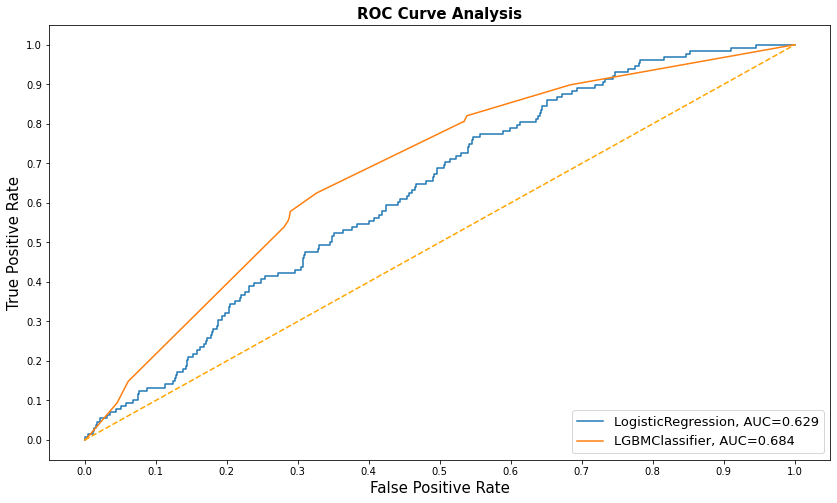

In [262]:
fig = plt.figure(figsize=(14,8))

for i in metric_table.index:
    plt.plot(metric_table.loc[i]['fpr'], 
             metric_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(metric_table.loc[i]['classifier'], metric_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

Nice! Our LGBM model's AUC has improved! Let's submit it!

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter.

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [288]:
mailout_test = pd.read_csv('../Capstone/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/Users/kozersky/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [289]:
mailout_test = mailout_test[list(azdias.columns) + ['LNR']]
## Clean the object columns for azdias
## We need to:
## 1. Replace strings like X or XX with missing values
## 2. Modify categorical variables to become dummy variables
## 3. Drop other column types
mailout_test = mailout_test.replace('X', np.nan).replace('XX', np.nan)
mailout_test['CAMEO_DEUG_2015'] = pd.to_numeric(mailout_test["CAMEO_DEUG_2015"])
mailout_test['CAMEO_INTL_2015'] = pd.to_numeric(mailout_test["CAMEO_INTL_2015"])
mailout_test['OST_WEST_KZ'] = [1 if x == 'W' else 0 for x in mailout_test['OST_WEST_KZ']]

mailout_test.dtypes.value_counts()

float64    248
int64       92
dtype: int64

In [290]:
my_model = LGBMClassifier(learning_rate= 0.005, n_estimators=8, num_leaves= 8, objective= 'binary', random_state= 0, reg_lambda= 1)

In [291]:
my_model.fit(mailout_train.drop(['RESPONSE', 'LNR'], axis = 1), mailout_train['RESPONSE'])

LGBMClassifier(learning_rate=0.005, n_estimators=8, num_leaves=8,
               objective='binary', random_state=0, reg_lambda=1)

In [298]:
predictions = my_model.predict_proba(mailout_test.drop(['LNR'], axis = 1))[:,1]
kaggle = pd.DataFrame(index=mailout_test['LNR'], data=predictions)
kaggle.rename(columns={0: "RESPONSE"}, inplace=True)

In [299]:
kaggle.head()

,RESPONSE
LNR,
1754,0.012602
1770,0.014453
1465,0.012042
1470,0.012042
1478,0.012165


In [302]:
kaggle.to_csv('kaggle.csv')

In [303]:
kaggle.shape

(42833, 1)